<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_VAE_Figures_Interpolation_Shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/200
32/32 - 7s - 233ms/step - loss: 2395.0952
Epoch 2/200
32/32 - 6s - 174ms/step - loss: 958.4886
Epoch 3/200
32/32 - 4s - 132ms/step - loss: 481.6569
Epoch 4/200
32/32 - 5s - 159ms/step - loss: 240.4376
Epoch 5/200
32/32 - 6s - 173ms/step - loss: 176.9914
Epoch 6/200
32/32 - 10s - 300ms/step - loss: 151.2886
Epoch 7/200
32/32 - 5s - 153ms/step - loss: 137.3309
Epoch 8/200
32/32 - 4s - 132ms/step - loss: 129.5088
Epoch 9/200
32/32 - 6s - 201ms/step - loss: 123.6181
Epoch 10/200
32/32 - 9s - 279ms/step - loss: 117.7203
Epoch 11/200
32/32 - 6s - 173ms/step - loss: 113.9371
Epoch 12/200
32/32 - 10s - 298ms/step - loss: 110.6826
Epoch 13/200
32/32 - 5s - 155ms/step - loss: 108.8135
Epoch 14/200
32/32 - 4s - 131ms/step - loss: 107.7666
Epoch 15/200
32/32 - 6s - 201ms/step - loss: 104.4688
Epoch 16/200
32/32 - 9s - 278ms/step - loss: 101.6268
Epoch 17/200
32/32 - 6s - 181ms/step - loss: 100.2402
Epoch 18/200
32/32 - 4s - 131ms/step - loss: 98.0713
Epoch 19/200
32/32 - 5s - 167ms/ste

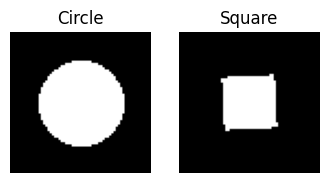

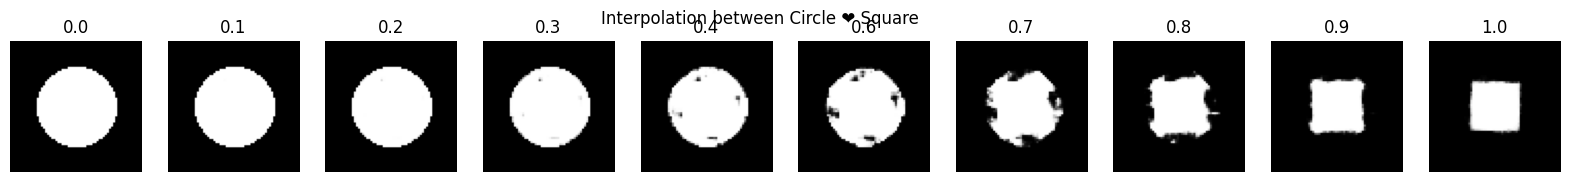

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from PIL import Image, ImageDraw

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ---
# 1. Utility to generate a synthetic shape image
# ---
def generate_shape(shape='circle', image_size=64, radius_range=(10, 25), angle_range=(0, 360)):
    img = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(img)
    cx = cy = image_size // 2

    if shape == 'circle':
        r = np.random.randint(*radius_range)
        draw.ellipse((cx-r, cy-r, cx+r, cy+r), fill=255)
    else: # square
        side = np.random.randint(*radius_range)
        sq = Image.new('L', (side, side), 0)
        d = ImageDraw.Draw(sq)
        d.rectangle((0, 0, side, side), fill=255)
        sq = sq.rotate(np.random.uniform(*angle_range), expand=True)
        w, h = sq.size
        img.paste(sq, (cx - w//2, cy - h//2), sq)

    arr = np.array(img, dtype='float32') / 255.0
    return arr[..., None]

# ---
# 2. Build the synthetic dataset
# ---
N = 2000
X = np.zeros((N, 64, 64, 1), dtype='float32')
for i in range(N):
    shape_type = 'circle' if i < N // 2 else 'square'
    X[i] = generate_shape(shape=shape_type)

# ---
# 3. Define the VAE architecture
# ---
latent_dim = 2

class Encoder(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')
        self.flat = layers.Flatten()
        self.mu = layers.Dense(latent_dim)
        self.lv = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        h = self.flat(x)
        return self.mu(h), self.lv(h)

class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(16 * 16 * 64, activation='relu')
        self.reshape = layers.Reshape((16, 16, 64))
        self.deconv1 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')
        self.deconv2 = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        x = self.deconv1(x)
        return self.deconv2(x)

class VAE(Model):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec

    def sample_z(self, mu, lv):
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * lv) * eps

    def call(self, x):
        mu, lv = self.enc(x)
        z = self.sample_z(mu, lv)
        x_hat = self.dec(z)

        rloss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_hat),
            axis=[1, 2]
        )
        kloss = -0.5 * tf.reduce_sum(
            1 + lv - tf.square(mu) - tf.exp(lv),
            axis=1
        )
        self.add_loss(tf.reduce_mean(rloss + kloss))
        return x_hat

# ---
# 4. Train the VAE
# ---
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(X, epochs=200, batch_size=64, verbose=2)

# ---
# 5. Build a Generator for new images
# ---
z_input = layers.Input(shape=(latent_dim,))
x_output = decoder(z_input)
generator = Model(z_input, x_output)

# ---
# 6. Display one new circle & one new square
# ---
circle_img = generate_shape('circle')
square_img = generate_shape('square')

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title('Circle')
plt.imshow(circle_img[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Square')
plt.imshow(square_img[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

# ---
# 7. Encode those shapes to latent means
# ---
mu1, lv1 = encoder.predict(circle_img[None], verbose=0)
mu2, lv2 = encoder.predict(square_img[None], verbose=0)

# ---
# 8. Interpolate in latent space & generate morph
# ---
n_steps = 10
alphas = np.linspace(0, 1, n_steps)
interp = []
for a in alphas:
    z = (1 - a) * mu1 + a * mu2
    xg = generator.predict(z, verbose=0)[0]
    interp.append(xg[:, :, 0])

# ---
# 9. Plot the interpolation sequence
# ---
plt.figure(figsize=(20, 2))
for i, img in enumerate(interp):
    ax = plt.subplot(1, n_steps, i + 1)
    plt.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{alphas[i]:.1f}')

plt.suptitle('Interpolation between Circle ❤ Square')
plt.show()